### Preliminaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

#Reconstruct results of ETL Notebook
orig_data = pd.read_csv("/content/drive/MyDrive/Learning/Data Science/IBM Advanced DS Certification/train.txt", delimiter= " ", header = None)
data = pd.read_csv("/content/drive/MyDrive/Learning/Data Science/IBM Advanced DS Certification/train.txt", delimiter= " ", header = None)
orig_data = orig_data.iloc[:, 0:26]
data = data.iloc[:, 0:26]
colNames = ["UnitNumber", "TimeCycle", "OpSetting1", "OpSetting2", "OpSetting3"]
sensorCols = ["SensorMeasurement_" + str(x) for x in range(1, 22)]
colNames.extend(sensorCols)
data.columns = colNames
orig_data.columns = colNames
#Compute Lifetime for each TurboFan Engine
usefulLife_df = pd.DataFrame(data["UnitNumber"].value_counts())
usefulLife_df.columns = ["UnitLife"]
usefulLife_df["UnitNumber"] = usefulLife_df.index
usefulLife_df = usefulLife_df.sort_values("UnitNumber")
usefulLife_df = usefulLife_df[["UnitNumber", "UnitLife"]].reset_index(drop = True)
#We'll join the `UnitLife` variable onto the original dataset and computer RUL
data = data.merge(usefulLife_df, how = "left", on = "UnitNumber")
data["RUL"] = data["TimeCycle"] - data["UnitLife"]

#Identify the Operation Configuration for each record
data["OpConfig"] = len(data)*[0]

for i in range(len(data)):
  if data.iloc[i, 4] > 80:
    data.iloc[i, -1] = 1
  
  elif data.iloc[i, 2] < 10:
    data.iloc[i, -1] = 2
  
  elif data.iloc[i, 4] < 20:
    data.iloc[i, -1] = 3
  
  elif data.iloc[i, 2] > 40:
    data.iloc[i, -1] = 4

  elif data.iloc[i, 2] > 30:
    data.iloc[i, -1] = 5
  
  else:
    data.iloc[i, -1] = 6

#Select only the useful features identified in the EDAandFE notebook
data = data[["UnitNumber", "TimeCycle", "OpConfig", "SensorMeasurement_3", "SensorMeasurement_4", "SensorMeasurement_9", "SensorMeasurement_11", "SensorMeasurement_14", "SensorMeasurement_15", "SensorMeasurement_17", "RUL"]].copy()
#Replace OpConfig with dummy variables
data = pd.get_dummies(data, columns = ["OpConfig"], drop_first = False)

##Split into Training, Test, and Safe Data

#Create a list of engines (unique unit numbers)
engines = list(data["UnitNumber"].unique())

#Function to shuffle and split engines into training, test, and safe sets
def split_units(units, random_state = 42, train_size = 0.7, test_size = 0.2):
  units2 = units.copy()
  random.Random(42).shuffle(units2)
  #print(units2)
  trainUnits = units2[:int(train_size*len(units))]
  testUnits = units2[int(train_size*len(units)):int((train_size + test_size)*len(units))]
  safeUnits = units2[int((train_size + test_size)*len(units)):]

  return trainUnits, testUnits, safeUnits

#Split engines into training, test, and safe sets -- ensuring no engines have been lost.
trainUnits, testUnits, safeUnits = split_units(engines, random_state = 42, train_size = 0.7, test_size = 0.2)

#Create training, test, and safe sets corresponding to engines chosen above
trainUnitsData = data[data["UnitNumber"].isin(trainUnits)].copy()
testUnitsData = data[data["UnitNumber"].isin(testUnits)].copy()
safeUnitsData = data[data["UnitNumber"].isin(safeUnits)].copy()

#Engineer the cumulative average sensor reading features
trainUnitsCumulative = trainUnitsData.copy()
trainUnitsCumulative["SensorMeasurment_3_CumAvg"] = trainUnitsData.groupby("UnitNumber")["SensorMeasurement_3"].apply(lambda x: x.shift().expanding().mean())
trainUnitsCumulative["SensorMeasurment_4_CumAvg"] = trainUnitsData.groupby("UnitNumber")["SensorMeasurement_4"].apply(lambda x: x.shift().expanding().mean())
trainUnitsCumulative["SensorMeasurment_9_CumAvg"] = trainUnitsData.groupby("UnitNumber")["SensorMeasurement_9"].apply(lambda x: x.shift().expanding().mean())
trainUnitsCumulative["SensorMeasurment_11_CumAvg"] = trainUnitsData.groupby("UnitNumber")["SensorMeasurement_11"].apply(lambda x: x.shift().expanding().mean())
trainUnitsCumulative["SensorMeasurment_14_CumAvg"] = trainUnitsData.groupby("UnitNumber")["SensorMeasurement_14"].apply(lambda x: x.shift().expanding().mean())
trainUnitsCumulative["SensorMeasurment_15_CumAvg"] = trainUnitsData.groupby("UnitNumber")["SensorMeasurement_15"].apply(lambda x: x.shift().expanding().mean())
trainUnitsCumulative["SensorMeasurment_17_CumAvg"] = trainUnitsData.groupby("UnitNumber")["SensorMeasurement_17"].apply(lambda x: x.shift().expanding().mean())

testUnitsCumulative = testUnitsData.copy()
testUnitsCumulative["SensorMeasurment_3_CumAvg"] = testUnitsData.groupby("UnitNumber")["SensorMeasurement_3"].apply(lambda x: x.shift().expanding().mean())
testUnitsCumulative["SensorMeasurment_4_CumAvg"] = testUnitsData.groupby("UnitNumber")["SensorMeasurement_4"].apply(lambda x: x.shift().expanding().mean())
testUnitsCumulative["SensorMeasurment_9_CumAvg"] = testUnitsData.groupby("UnitNumber")["SensorMeasurement_9"].apply(lambda x: x.shift().expanding().mean())
testUnitsCumulative["SensorMeasurment_11_CumAvg"] = testUnitsData.groupby("UnitNumber")["SensorMeasurement_11"].apply(lambda x: x.shift().expanding().mean())
testUnitsCumulative["SensorMeasurment_14_CumAvg"] = testUnitsData.groupby("UnitNumber")["SensorMeasurement_14"].apply(lambda x: x.shift().expanding().mean())
testUnitsCumulative["SensorMeasurment_15_CumAvg"] = testUnitsData.groupby("UnitNumber")["SensorMeasurement_15"].apply(lambda x: x.shift().expanding().mean())
testUnitsCumulative["SensorMeasurment_17_CumAvg"] = testUnitsData.groupby("UnitNumber")["SensorMeasurement_17"].apply(lambda x: x.shift().expanding().mean())

safeUnitsCumulative = safeUnitsData.copy()
safeUnitsCumulative["SensorMeasurment_3_CumAvg"] = safeUnitsData.groupby("UnitNumber")["SensorMeasurement_3"].apply(lambda x: x.shift().expanding().mean())
safeUnitsCumulative["SensorMeasurment_4_CumAvg"] = safeUnitsData.groupby("UnitNumber")["SensorMeasurement_4"].apply(lambda x: x.shift().expanding().mean())
safeUnitsCumulative["SensorMeasurment_9_CumAvg"] = safeUnitsData.groupby("UnitNumber")["SensorMeasurement_9"].apply(lambda x: x.shift().expanding().mean())
safeUnitsCumulative["SensorMeasurment_11_CumAvg"] = safeUnitsData.groupby("UnitNumber")["SensorMeasurement_11"].apply(lambda x: x.shift().expanding().mean())
safeUnitsCumulative["SensorMeasurment_14_CumAvg"] = safeUnitsData.groupby("UnitNumber")["SensorMeasurement_14"].apply(lambda x: x.shift().expanding().mean())
safeUnitsCumulative["SensorMeasurment_15_CumAvg"] = safeUnitsData.groupby("UnitNumber")["SensorMeasurement_15"].apply(lambda x: x.shift().expanding().mean())
safeUnitsCumulative["SensorMeasurment_17_CumAvg"] = safeUnitsData.groupby("UnitNumber")["SensorMeasurement_17"].apply(lambda x: x.shift().expanding().mean())

trainUnitsCumulative = trainUnitsCumulative.fillna(0)
testUnitsCumulative = testUnitsCumulative.fillna(0)
safeUnitsCumulative = safeUnitsCumulative.fillna(0)

#Linear Regression
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(trainUnitsCumulative.drop(["UnitNumber", "RUL"], axis = 1).fillna(0), trainUnitsCumulative["RUL"])

#print("Intercept: ", lin_reg.intercept_)
#print("Coefficients: ", pd.DataFrame({"Feature" : trainUnitsCumulative.drop(["UnitNumber", "RUL"], axis = 1).columns, "Coefficient" : lin_reg.coef_}))

#Deep Learning
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

X_train = trainUnitsData.drop(["UnitNumber", "RUL"], axis = 1)
y_train = trainUnitsData["RUL"]

##Fully-Connected Neural Network
model = None
model = Sequential()
model.add(Dense(units = 8, input_dim = len(X_train.columns)))
model.add(Dense(units = 16))
model.add(Dense(1))

model.compile(loss = "mse", optimizer = "adam")

X_test = testUnitsData.drop(["UnitNumber", "RUL"], axis = 1)
y_test = testUnitsData["RUL"]

model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 20)

##LSTM Recurrent Neural Network
def lstm_data_transform(X_data, y_data, num_steps = 5):
  X, y = list(), list()

  for i in range(X_data.shape[0]):
    end_ix = i + num_steps

    if end_ix >= X_data.shape[0]:
      break

    seq_X = X_data[i:end_ix]
    seq_y = y_data[end_ix]

    X.append(seq_X)
    y.append(seq_y)
  
  x_array = np.array(X)
  y_array = np.array(y)

  return x_array, y_array

trainUnitsData.reset_index(inplace = True, drop = True)

my_train_data, my_train_y = lstm_data_transform(trainUnitsData.drop(["UnitNumber", "RUL"], axis = 1), trainUnitsData["RUL"])

model2 = Sequential()

model2.add(LSTM(10, input_shape = (5, 14)))
model2.add(Dense(32))
model2.add(Dense(1))

model2.compile(loss = "mse", optimizer = "adam")

model2.fit(my_train_data, my_train_y, epochs = 20)

##Scaled LSTM
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_train_data = scaler.fit_transform(trainUnitsData.drop(["UnitNumber", "RUL"], axis = 1))

my_train_data, my_train_y = lstm_data_transform(scaled_train_data, trainUnitsData["RUL"])

model2.fit(my_train_data, my_train_y, epochs = 20)

##Scaled LSTM with Cumulative Features
scaler = MinMaxScaler()

trainUnitsCumulative.reset_index(inplace = True, drop = True)

scaled_train_data = scaler.fit_transform(trainUnitsCumulative.drop(["UnitNumber", "RUL"], axis = 1))

my_train_data, my_train_y = lstm_data_transform(scaled_train_data, trainUnitsCumulative["RUL"])

model3 = Sequential()

model3.add(LSTM(10, input_shape = (5, 21)))
model3.add(Dense(32))
model3.add(Dense(1))

model3.compile(loss = "mse", optimizer = "adam")

model3.fit(my_train_data, my_train_y, epochs = 20)

#Print out the head of the training set
trainUnitsCumulative.head()

Epoch 1/20
1018/1018 [==============================] - 3s 2ms/step - loss: 5510.7686 - val_loss: 4044.0837
Epoch 2/20
1018/1018 [==============================] - 2s 2ms/step - loss: 2620.5774 - val_loss: 3044.4255
Epoch 3/20
1018/1018 [==============================] - 2s 2ms/step - loss: 2510.2563 - val_loss: 2025.7908
Epoch 4/20
1018/1018 [==============================] - 2s 2ms/step - loss: 2509.0195 - val_loss: 1871.0115
Epoch 5/20
1018/1018 [==============================] - 2s 2ms/step - loss: 2401.0000 - val_loss: 2019.2120
Epoch 6/20
1018/1018 [==============================] - 2s 2ms/step - loss: 2307.1179 - val_loss: 1956.3447
Epoch 7/20
1018/1018 [==============================] - 2s 2ms/step - loss: 2274.1697 - val_loss: 3406.6787
Epoch 8/20
1018/1018 [==============================] - 2s 2ms/step - loss: 2304.0767 - val_loss: 1741.2196
Epoch 9/20
1018/1018 [==============================] - 2s 2ms/step - loss: 2267.6094 - val_loss: 1744.1051
Epoch 10/20
1018/1018 [=====

,UnitNumber,TimeCycle,SensorMeasurement_3,SensorMeasurement_4,SensorMeasurement_9,SensorMeasurement_11,SensorMeasurement_14,SensorMeasurement_15,SensorMeasurement_17,RUL,...,OpConfig_4,OpConfig_5,OpConfig_6,SensorMeasurment_3_CumAvg,SensorMeasurment_4_CumAvg,SensorMeasurment_9_CumAvg,SensorMeasurment_11_CumAvg,SensorMeasurment_14_CumAvg,SensorMeasurment_15_CumAvg,SensorMeasurment_17_CumAvg
0,1,1,1499.45,1309.95,8770.20,45.40,8120.83,8.6216,368,-222,...,0,0,1,0.000000,0.000,0.000000,0.0000,0.000000,0.000000,0.000000
1,1,2,1584.55,1403.96,9045.76,47.29,8132.87,8.3907,391,-221,...,0,0,0,1499.450000,1309.950,8770.200000,45.4000,8120.830000,8.621600,368.000000
2,1,3,1368.17,1122.49,8343.91,41.92,8063.84,9.3557,334,-220,...,0,1,0,1542.000000,1356.955,8907.980000,46.3450,8126.850000,8.506150,379.500000
3,1,4,1488.44,1249.18,8721.53,44.26,8052.30,9.2231,364,-219,...,0,0,0,1484.056667,1278.800,8719.956667,44.8700,8105.846667,8.789333,364.333333
4,1,5,1354.48,1124.32,8314.56,41.79,8083.67,9.2986,330,-218,...,1,0,0,1485.152500,1271.395,8720.350000,44.7175,8092.460000,8.897775,364.250000


## Stakeholders Information

We are applying for $225,000 in seed funding to help the US DOD predict the remaining useful life for turbofan jet engines. The funding initiative is offered through the [Small Business Innovation Research Program (SBIR.gov)](https://www.sbir.gov/). We obtained a dataset including streamed sensor readings from a set of 218 of these engines, which we then split into 152 training engines, 44 test engines, and 22 safe engines.

The distribution of lifetimes for the 152 training engines can be seen below. 

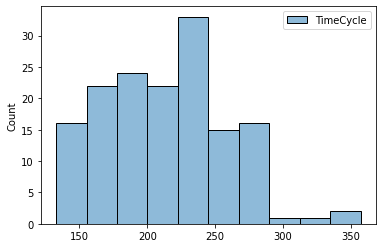

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(trainUnitsData[["UnitNumber", "TimeCycle"]].groupby("UnitNumber").agg("max"))

We can see that the average engine historically lasts for around 230 time cycles.There is quite a bit of variation in this lifetime though, with the longest-lasting engines running more than 300 time cycles and the least durable running below 150 time cycles.

The goal of this project is to take streaming sensor data and use it to predict the remaining useful life for the corresponding engine. Successful models will allow for preventative maintenance (maintanence when maintanence is needed, rather than simply on a regularly scheduled interval). 

## Results

After building four initial models:

+ A linear regression model
+ A fully-connected neural network with two hidden layers
+ An LSTM network
+ An LSTM network with pre-engineered cumulative sensor averages and scaled data

We found that, without much tuning, we are able to predict remaining useful life with an RMSE of about 35 time cycles. That is, we expect our predictions to be accurate within $\pm \sim 70$ time cycles at 95% confidence. Interestingly, our MAE (which is not as greatly influenced by outlying prediction errors) agrees with our RMSE at errors of about $\pm \sim 70$ time cycles.

Given the histogram of useful lifetimes above, this $\pm ~70$ cycles is certainly a first-pass benchmark. Advanced models constructed during Phase 1 (the *proof of merit* and *exploratory* phase) of the grant period are expected to surpass this threshold. We hope that this proof of concept report, shows our capability to construct predictive maintanence models and convinces you of our ability to build more advanced models which will predict RUL with much greater accuracy.

## Potential Future Directions

There is much that can be done to optimize the performance of our current models. For instance, all of the models considered had two hidden layers. We expect to experiment with more or fewer layers, in particular it will be interesting to consider the placement of LSTM layers internal to the network. We also expect to observe benefit by tuning the number of neurons at each hidden layer.

Beyond optimizing our existing models, there are other model classes which can be considered. In particular, one model of interest is a Similarity-Based model, which uses a Nearest Neighbors approach and the distribution of RUL for all of those nearest neighbors to make a prediction.

Other approaches include stacking models. For instance, we might use one initial model (a classifier) to indicate whether a model is in its last 50 operational time cycles, and follow that model up with a regressor or neural network to predict RUL for those engines which we believe are nearing EOL (within their last 50 operational time cycles). There are many promising future directions with which we can improve on the preliminary models presented here. 

## Model Details (for Analysts and Scientists)

This section contains the details of the model construction and the justification for choices that were made as part of the initial modeling process.

### Initial Exploratory Analysis

As part of our initial exploratory data analysis, we explored how the Operational Settings (`OpSetting_1`, `OpSetting_2`, and `OpSetting_3`) were utilized throughout the data collection phase. In doing this, we observed that each engine was operating under one of six operational configurations, as seen below.

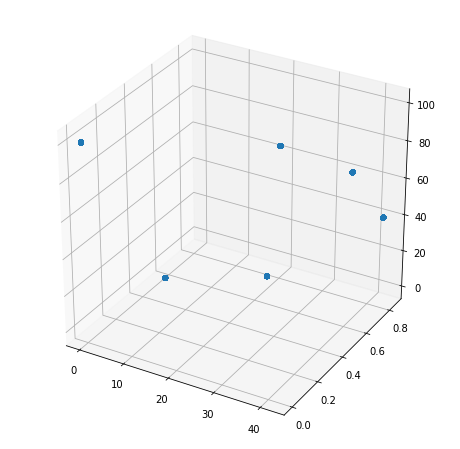

In [50]:
orig_data = pd.read_csv("/content/drive/MyDrive/Learning/Data Science/IBM Advanced DS Certification/train.txt", delimiter= " ", header = None)
orig_data = orig_data.iloc[:, 0:26]
colNames = ["UnitNumber", "TimeCycle", "OpSetting1", "OpSetting2", "OpSetting3"]
sensorCols = ["SensorMeasurement_" + str(x) for x in range(1, 22)]
colNames.extend(sensorCols)
orig_data.columns = colNames

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(projection = "3d")

ax.scatter(orig_data["OpSetting1"], orig_data["OpSetting2"], orig_data["OpSetting3"])

We used this finding to engineer a new feature called `OpSetting`, which encoded which of the six operational configurations the engine was running in at a given time period.

From there, we considered the sensor streams and identified that several of the sensor readings began a slight climb as the unit neared its end of life. This can be seen in the plots below.

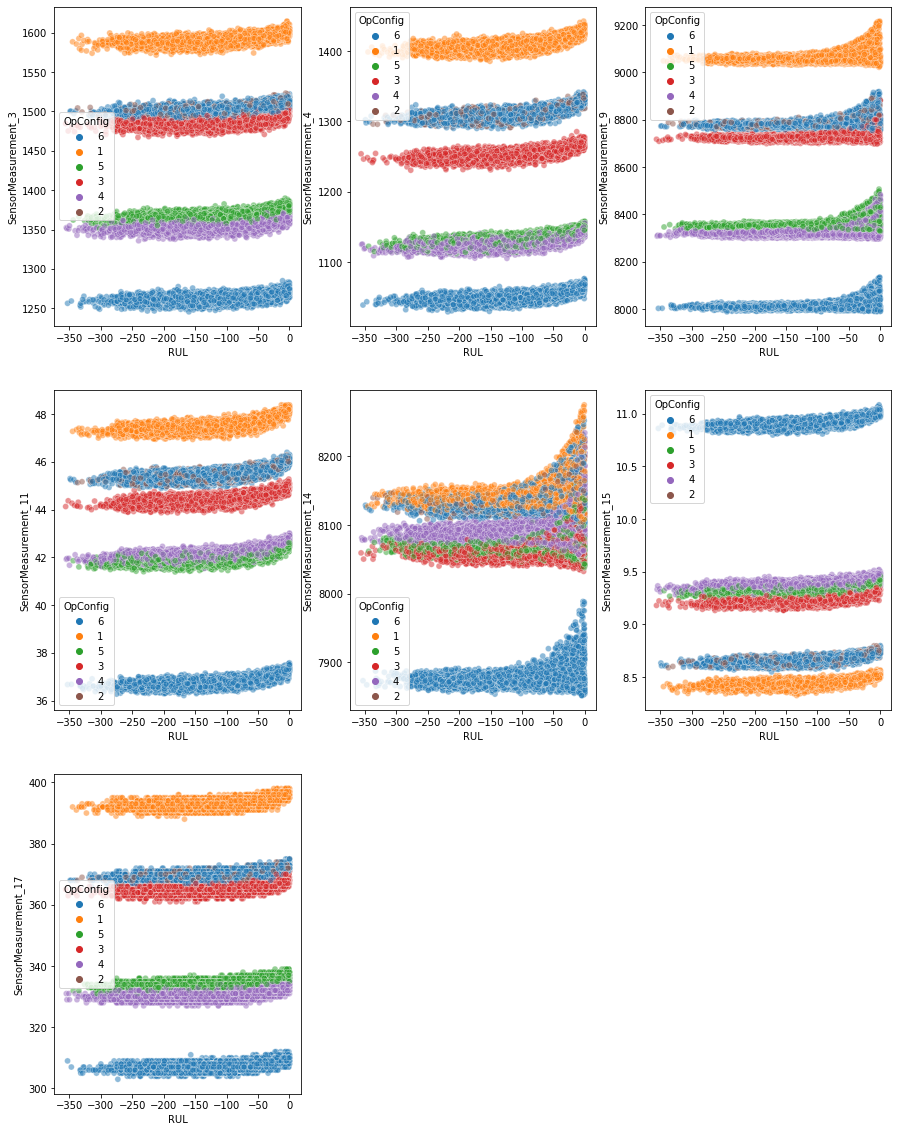

In [51]:
orig_data["OpConfig"] = len(orig_data)*[0]

for i in range(len(orig_data)):
  if orig_data.iloc[i, 4] > 80:
    orig_data.iloc[i, -1] = 1
  
  elif orig_data.iloc[i, 2] < 10:
    orig_data.iloc[i, -1] = 2
  
  elif orig_data.iloc[i, 4] < 20:
    orig_data.iloc[i, -1] = 3
  
  elif orig_data.iloc[i, 2] > 40:
    orig_data.iloc[i, -1] = 4

  elif orig_data.iloc[i, 2] > 30:
    orig_data.iloc[i, -1] = 5
  
  else:
    orig_data.iloc[i, -1] = 6

orig_data = orig_data.merge(usefulLife_df, how = "left", on = "UnitNumber")
orig_data["RUL"] = orig_data["TimeCycle"] - orig_data["UnitLife"]

plt.figure(figsize = (15, 20))
sensorList = [3, 4, 9, 11, 14, 15, 17]
for i in range(len(sensorList)):
  plt.subplot(3, 3, i+1)
  sns.scatterplot(x = orig_data["RUL"], y = orig_data["SensorMeasurement_" + str(sensorList[i])], hue = orig_data["OpConfig"].astype(str), alpha = 0.5)

The sensor streams not shown above were largely flatline when plotted against the `RUL` variable. As such, they were dropped from the dataset once we moved forward into the model construction and assessment phase of the proposal.

### Model Construction

Having identified the six operational configurations, and isolated those sensors showing some deviation from the norm as end of life approached, we were ready to move forward to the modeling phase of the proposal. 

#### Pre-Processing

We took the following pre-processing steps as we entered this phase.

+ OneHot encode the `OpConfig` variable into dummy columns. We do this since this variable is nominal-categorical -- it is not even ordinal, nevermind a ratio-level variable. That is, `OpConfig_6` is not six times better (or six times worse) than `OpConfig_1`, which would be the assumption made without this dummy encoding.
+ Remove all sensor streams that did not show an association with EOL.
+ Group by engine number, and compute a cumulative average reading for each sensor stream. This will allow us to track whether new values of the stream are consistently pulling the cumulative average up -- indicating near EOL for the unit.

  + The first entry in each of these cumulative average columns for each engine will be `NA`, since there is no prior data to compute an average with. We'll simply fill these missing values with 0 for now. Other approaches (such as dropping these first time cycles) may prove to be better paths in future work.

Having completed our pre-processing, we move forward to our four initial candidate models.

#### Candidate Model 1: Multiple Linear Regression

We started simple, with a multiple linear regression model. Engineering those cumulative average features corresponding to each relevant sensor stream serves to give this simple model some ability to track historical patterns. That is, we have manufactured some *memory* for this model.

In [52]:
import pandas as pd

print("Intercept: \t", lin_reg.intercept_)
print("\n")
print(pd.DataFrame({"Feature Name" : trainUnitsCumulative.drop(["UnitNumber", "RUL"], axis = 1).columns, "Estimate" : lin_reg.coef_}))

print("\n")
print("Test RMSE: ", (((testUnitsCumulative["RUL"] - lin_reg.predict(testUnitsCumulative.drop(["UnitNumber", "RUL"], axis = 1)))**2).mean())**0.5)

Intercept: 	 -7534.16734633543


                  Feature Name    Estimate
0                    TimeCycle    0.495564
1          SensorMeasurement_3    0.405731
2          SensorMeasurement_4    0.838880
3          SensorMeasurement_9   -0.084990
4         SensorMeasurement_11   41.773349
5         SensorMeasurement_14    0.087325
6         SensorMeasurement_15  343.315964
7         SensorMeasurement_17    2.188866
8                   OpConfig_1 -171.122826
9                   OpConfig_2  -14.780288
10                  OpConfig_3  -99.835652
11                  OpConfig_4  144.616348
12                  OpConfig_5  155.318322
13                  OpConfig_6  -14.195904
14   SensorMeasurment_3_CumAvg   -2.414589
15   SensorMeasurment_4_CumAvg   -0.294365
16   SensorMeasurment_9_CumAvg    0.550480
17  SensorMeasurment_11_CumAvg   -1.392119
18  SensorMeasurment_14_CumAvg   -0.217167
19  SensorMeasurment_15_CumAvg  -24.502092
20  SensorMeasurment_17_CumAvg    3.304439


Test RMSE:  35.4878

We can see, and analyze, the model coefficients for our multiple linear regression model. Additionally, we see that the model has a test RMSE of about 35.5 time cycles, as highlighted in the Results section from earlier.

#### Dense Neural Network

The second type of model we chose to consider was a neural network with a single hidden dense layer. This neural network has no recurrent nodes, and therefore no *memory*. The network has no meaningful coefficients to examine, but we can see how well the network performed on the test data. Below, the network architecture is printed out, and the RMSE on the test engines is displayed.

In [53]:
print(model.summary())
print("Test RMSE: ", (((y_test - model.predict(X_test)[:, 0])**2).mean())**0.5)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 8)                 120       
                                                                 
 dense_15 (Dense)            (None, 16)                144       
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                                 
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________
None
Test RMSE:  38.52750778528364


We can see that our first neural network does not do quite as well on the test data as the multiple linear regression model did. It should be pointed out, however, that this model didn't have access to the cumulative average features we engineered. Because of this fact and, due to the structure of the model, this network had no ability to utilize past information.

#### LSTM Network

We now build our first LSTM network. Similar to the previous network, we'll print out the architecture and our model's RMSE score on the test engines.

In [54]:
testUnitsData.reset_index(inplace = True, drop = True)

scaler = MinMaxScaler()
scaler.fit(trainUnitsData.drop(["UnitNumber", "RUL"], axis = 1))

testUnitsData_scaled = scaler.transform(testUnitsData.drop(["UnitNumber", "RUL"], axis = 1))

my_test_data, my_test_y = lstm_data_transform(testUnitsData_scaled, testUnitsData["RUL"])

print(model2.summary())
print("\n")
print("Test RMSE: ", (((my_test_y - model2.predict(my_test_data))**2).mean())**0.5)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10)                1000      
                                                                 
 dense_17 (Dense)            (None, 32)                352       
                                                                 
 dense_18 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,385
Trainable params: 1,385
Non-trainable params: 0
_________________________________________________________________
None


Test RMSE:  87.29316500079918


This model seems to have performed much more poorly than our earlier two models. Let's try allowing the LSTM to have access to the cumulative sensor average features we engineered earlier.

#### LSTM Network with Cumulative Averages

Our final model is the same LSTM network, but with access to those cumulative sensor stream averages. The architecture and performance appear below.

In [55]:
testUnitsCumulative.reset_index(inplace = True, drop = True)

scaler = MinMaxScaler()
scaler.fit(trainUnitsCumulative.drop(["UnitNumber", "RUL"], axis = 1))
test_data_scaled = scaler.transform(testUnitsCumulative.drop(["UnitNumber", "RUL"], axis = 1))

my_test_data, my_test_y = lstm_data_transform(test_data_scaled, testUnitsData["RUL"])

print(model3.summary())
print("\n")
print("Test RMSE: ", (((my_test_y - model3.predict(my_test_data))**2).mean())**0.5)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 10)                1280      
                                                                 
 dense_19 (Dense)            (None, 32)                352       
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________
None


Test RMSE:  88.9860327978214


## Summary

Check these RMSE values against those observed in the initial model building and assessment notebook. They seem higher than what I remember.